In [1]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [2]:
x_MainFoil, y_MainFoil = numpy.loadtxt('NACA23012_MainFoil.csv', delimiter=',', unpack=True)
x_FlapFoil, y_FlapFoil = numpy.loadtxt('NACA23012_FlapFoil.csv', delimiter=',', unpack=True)

(-0.5, 0.5)

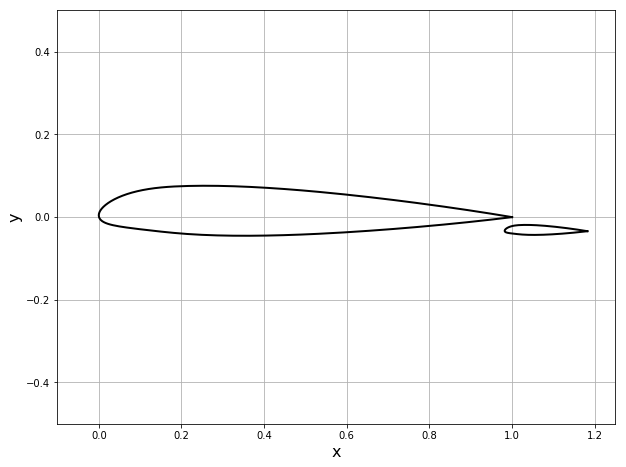

In [5]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_MainFoil, y_MainFoil, x_FlapFoil, y_FlapFoil, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.25)
pyplot.ylim(-0.5, 0.5)